In [8]:
using Pkg
Pkg.activate(@__DIR__)

  Activating environment at `~/Julia/doc/cscs_gpu_course/Project.toml`


In [3]:
using CUDA

# Application analysis and optimization

Accurately measuring execution time of GPU operations and its kernels is obviously important in order to optimize your application, but is complicated by the fact that GPU operations often run asynchronously, and on a different device (so Julia's existing tools generally don't work). In this notebook, I'll explain the different alternatives, and how to best use them.

## Time measurements

In Julia, we're used to using `@time`, `@elapsed`, and BenchmarkTools.jl for measuring the time it takes to execute some code. These tools can be used with code that performs GPU operations, but there's a caveat:

In [2]:
A = CUDA.rand(Float32, 1024, 1024);
B = CUDA.rand(Float32, 1024, 1024);

# warmup
A * B

# measure time
@time A * B;

  0.000070 seconds (32 allocations: 624 bytes)


The main problem with this measurement is that GPU operations are asynchronous, so we're really measuring the time to *submit* this operation, not the time it takes to complete it. To accurately measure execution time, we need to synchronize:

In [3]:
# make sure the GPU is idle _before_ starting the measurement
synchronize()

@time begin
    A * B
    synchronize()
end

  0.033050 seconds (77.19 k allocations: 4.149 MiB, 98.90% compilation time)


This is exactly what CUDA.jl's version of the `@time` macro does. In addition, it reports on GPU allocations; `Base.@time` only reports CPU allocations:

In [4]:
CUDA.@time A * B;

  0.001398 seconds (47 CPU allocations: 1.375 KiB) (1 GPU allocation: 4.000 MiB, 0.78% memmgmt time)


If you need to access these timings programmatically, you can use CUDA.jl's version of the `@timed` macro:

In [5]:
CUDA.@timed A * B

(value = Float32[255.13716 258.35574 … 268.787 264.22656; 267.99973 272.66614 … 274.87433 274.34445; … ; 250.27515 254.57367 … 262.51657 259.36014; 254.1278 257.36093 … 261.0692 260.70612], time = 0.000495133, cpu_bytes = 1408, cpu_gctime = 0.0, cpu_gcstats = Base.GC_Diff(1408, 0, 0, 47, 0, 0, 0, 0, 0), gpu_bytes = 4194304, gpu_memtime = 9.659999999994673e-6, gpu_memstats = CUDA.AllocStats(1, 4194304, 0, 0, 9.659999999994673e-6))

For even simpler measurements, you can use `CUDA.@elapsed` behaving like `Base.@elapsed`. One minor difference to the other macros, is that it uses events to measure time and does not synchronize the entire stream, so it is a better mechanism when your application needs timings without disturbing the execution:

In [6]:
CUDA.@elapsed A * B

0.00039916803f0

## Benchmarks

Most of the time, you shouldn't bother with these simple measurements and move on to BenchmarkTools.jl. The same rules apply -- make sure you synchronize the GPU so that actual execution time is measured -- but because BenchmarkTools.jl performs multiple iterations it's sufficient to synchronize at the end. The `CUDA.@sync` macro is very useful for that:

In [7]:
using BenchmarkTools
b = @benchmark CUDA.@sync A * B

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  261.506 μs … 271.158 ms  ┊ GC (min … max): 0.00% … 0.95%
 Time  (median):     288.875 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   408.683 μs ±   4.672 ms  ┊ GC (mean ± σ):  0.17% ± 0.01%

   ▇▆█▂ ▁      ▂▃▁  ▂▄▁                                         ▁
  ▄██████▇▇▅▅▂▄████▇████▇▆▅▆▆▇▆▅▅▄▆▇▆▅▇▆▆▆▇▇▆▅▆▇▆▄▃▄▄▄▇█▇▆▇▄▅▆▆ █
  262 μs        Histogram: log(frequency) by time        793 μs <

 Memory estimate: 1.38 KiB, allocs estimate: 47.

This profile may look noisy, but that's just because of the logarithmic display of the frequency:

In [8]:
ioctx = IOContext(stdout, :logbins=>false)
show(ioctx, MIME("text/plain"), b);

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  261.506 μs … 271.158 ms  ┊ GC (min … max): 0.00% … 0.95%
 Time  (median):     288.875 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   408.683 μs ±   4.672 ms  ┊ GC (mean ± σ):  0.17% ± 0.01%

   ▂ █                                                           
  ▁█▇█▂▁▁▁▁▁▁▁▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁
  262 μs           Histogram: frequency by time          793 μs <

 Memory estimate: 1.38 KiB, allocs estimate: 47.

### Pitfall: captured benchmark inputs

BenchmarkTools.jl has one BIG gotcha, however: [Captured inputs are never released](https://github.com/JuliaCI/BenchmarkTools.jl/issues/127). That means the following function would leak memory:

In [9]:
function benchmark1()
    A = CUDA.rand(Float32, 1024, 1024)
    B = CUDA.rand(Float32, 1024, 1024)
    @benchmark CUDA.@sync $A * $B
end

benchmark1 (generic function with 1 method)

Luckily, there's two workarounds. The first is a hack; telling CUDA.jl to early-free the memory:

In [10]:
function benchmark2()
    A = CUDA.rand(Float32, 1024, 1024)
    B = CUDA.rand(Float32, 1024, 1024)
    b = @benchmark CUDA.@sync $A * $B
    CUDA.unsafe_free!(A)
    CUDA.unsafe_free!(B)
    b
end
benchmark2()

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  270.505 μs … 269.621 ms  ┊ GC (min … max): 0.00% … 1.00%
 Time  (median):     289.166 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   404.793 μs ±   4.665 ms  ┊ GC (mean ± σ):  0.18% ± 0.02%

  ▇▇█▃         ▄▃▂▁ ▂▄▁            ▁                            ▂
  █████▇▇▄▅▆▁▃▁████▇████▇▆▃▆█▇▆▇▆▆▆█▇▆▇▆▇▆▆▅▆▅▅▆▇▇▆▅▅▅▅▄██▅███▇ █
  271 μs        Histogram: log(frequency) by time        775 μs <

 Memory estimate: 1.38 KiB, allocs estimate: 47.

The alternative is to not capture inputs, but instead tell BenchmarkTools how to create them right before the test is executed:

In [11]:
@benchmark CUDA.@sync(a * b) setup=(a=CUDA.rand(1024,1024); b=CUDA.rand(1024,1024))

BenchmarkTools.Trial: 8027 samples with 1 evaluation.
 Range (min … max):  246.556 μs … 264.665 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     290.716 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   566.427 μs ±   7.760 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃█▆      ▁▁ ▄▂                                              ▁
  ▇▅████▅▆▆▅███▇██▇█▆▆▇▄▅▅▄▇▄▆▇▄▃▄▄▅▄▄▃▄▂▆▆▅▇▆█▆▅▃▄▃▅▃▄▄▅▅▅▄▄▄▄ █
  247 μs        Histogram: log(frequency) by time        997 μs <

 Memory estimate: 624 bytes, allocs estimate: 32.

## Profiling

Similarly, because of the asynchronous CPU execution of GPU operations we cannot simply profile code:

In [12]:
using Profile
@bprofile CUDA.@sync A * B
Profile.print(; noisefloor=30.)

Overhead ╎ [+additional indent] Count File:Line; Function
     ╎2410  @Base/task.jl:411; (::IJulia.var"#15#18")()
     ╎ 2410  ...ia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
     ╎  2410  @Base/essentials.jl:714; invokelatest
     ╎   2410  @Base/essentials.jl:716; #invokelatest#2
     ╎    2410  ...xecute_request.jl:67; execute_request(socket::ZMQ....
     ╎     2410  ...oftGlobalScope.jl:65; softscope_include_string(m:...
     ╎    ╎ 2410  @Base/loading.jl:1196; include_string(mapexpr::t...
    1╎    ╎  2410  @Base/boot.jl:373; eval
     ╎    ╎   2409  ...rc/execution.jl:116; run(b::BenchmarkTools.Ben...
     ╎    ╎    2409  ...rc/execution.jl:116; run
     ╎    ╎     2409  ...rc/execution.jl:116; run(b::BenchmarkTools.Be...
     ╎    ╎    ╎ 2409  ...rc/execution.jl:33; run_result
     ╎    ╎    ╎  2409  ...c/execution.jl:33; #run_result#45
     ╎    ╎    ╎   2409  ...essentials.jl:714; invokelatest
     ╎    ╎    ╎    2409  ...essentials.jl:716; #invokelatest#2
     ╎    ╎ 

There isn't even a trace of the matrix multiplication in the profile output; all time is spent synchronizing! That means we'll need a GPU-specific profiler to visualize what's happening on the GPU, instead of analyzing the execution from the CPU side. CUDA.jl currently does not have such a profiler -- although it's [possible](https://docs.nvidia.com/cupti/r_main.html#r_pc_sampling_api) to implement one using CPUTI, that would take a lot of work, and the existing NVIDIA tools are pretty good already.

### NVIDIA Nsight

NVIDIA has some great tools for profiling GPU code, bundled under the NVIDIA Nsight suite. There are several tools, one for each type of GPU application, and these replace the old monolithic profiler (`nvprof` and `nvvp`) which are now deprecated.

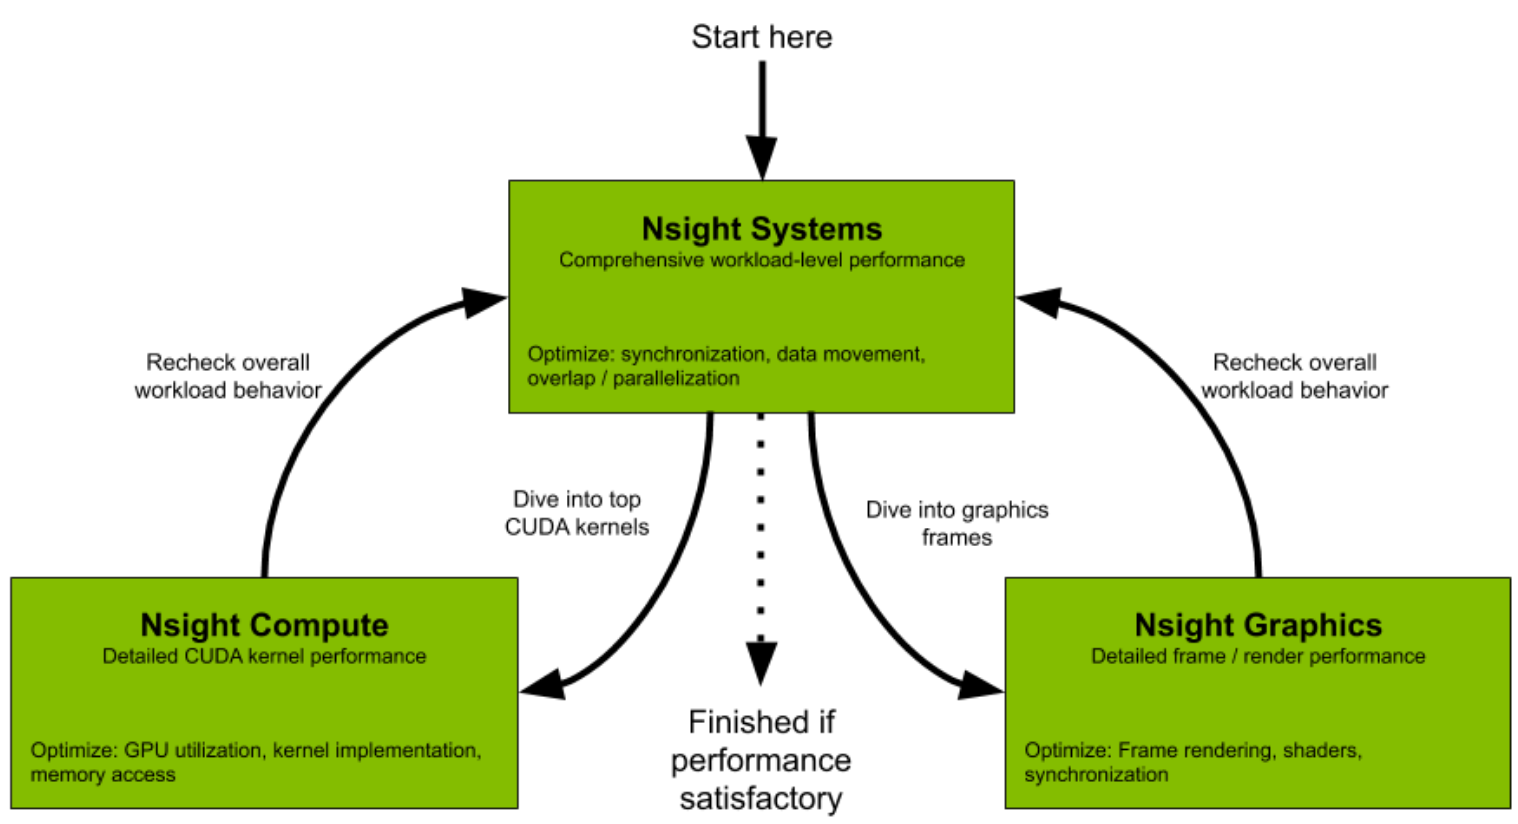

## NVIDIA Nsight Systems

The first NSight tool you should probably use to profile a GPU application, is NSight Systems. This tool gives an application-level overview, including a handy timeline, quickly visualizing times during execution where the GPU is underutilized and which operations are to blame for that.

The tool has two modes of operation:
- profile: run an application and profile at the end
- launch: launch an application for interactive profiling

There is also two ways of running the profiler:
- using the `nsys` binary on one end, and `nsys-ui` to visualize the result
- using `nsys-ui` to set-up and launch `nsys` automatically

First, verify that you can SSH to Piz Daint:

```
ssh -J class99@ela.cscs.ch class99@daint.cscs.ch
```

On the login node, activate the necessary modules and request an interactive session:

```
module load daint-gpu
module load Julia
srun -C gpu -n 1 -A class01 --time=00:30:00 --pty /bin/bash -l
```

Once our job has been allocated resources, launch Julia under `nsys`:

```
cd /scratch/snx3000/class99
nsight-systems-2021.4.1/bin/nsys launch julia
```

Note that it's better to run from somewhere in `/scratch`, because the home folder file system is slow and the profiling process mighth time out. Let's now try and benchmark the matrix multiplication from above.

In [13]:
using CUDA

A = CUDA.rand(Float32, 1024, 1024);
B = CUDA.rand(Float32, 1024, 1024);

# warmup
A * B

# profile execution
CUDA.@profile CUDA.@sync A * B;

┌ Warning: Calling CUDA.@profile only informs an external profiler to start.
│ The user is responsible for launching Julia under a CUDA profiler.
│ 
│ It is recommended to use Nsight Systems, which supports interactive profiling:
│ $ nsys launch julia
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:71


```
[ Info: Running under Nsight Systems, CUDA.@profile will automatically start the profiler

WARNING: CUDA tracing is required for cudaProfilerStart/Stop API support. Turning it on by default.
waiting for capture range to start the collection
Capture range started in the application
Capture range ended in the application
Processing events...
Saving temporary "/tmp/nsys-report-16b1-96f1-9095-b9f1.qdstrm" file to disk...

Creating final output files...
Processing [===============================================================100%]
Saved report file to "/tmp/nsys-report-16b1-96f1-9095-b9f1.nsys-rep"
Report file moved to "/scratch/snx3000/class99/report1.nsys-rep"

command ignored
[ Info: Profiling has finished, open the report listed above with `nsight-sys`
```

We now need to transfer this report file to our local system. You can do this using command-line tools like `scp`, or graphical tools like `WinSCP` or `FileZilla`. For those familiar with `sshfs`, it's even easier to mount the remote directory locally so that no transfers are required.

```
scp -J class99@ela.cscs.ch class99@daint.cscs.ch:/scratch/snx3000/class99/report1.nsys-rep .
```

To view this file, you need the NSight Systems viewer locally. Download this from [the NVIDIA website](https://developer.nvidia.com/nsight-systems), which requires an NVIDIA developer account to access. Once that's done, launch `nsys-ui` and open the report file.

Once you zoom in on the timeline, you should see the kernel invocation:

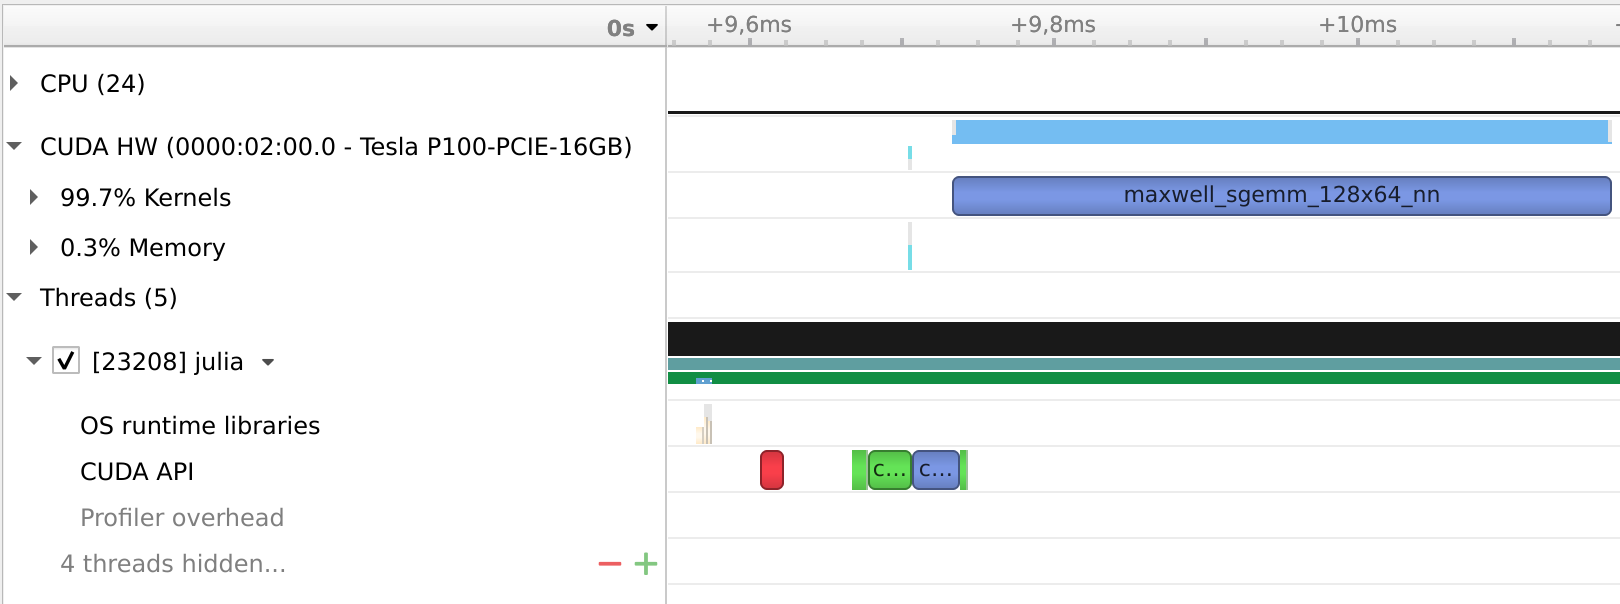

It's also possible to run Jupyter under NSight Systems, by adapting and adding the following kernel definition to `.local/share/jupyter/kernels`:

```
{
  "display_name": "Julia 1.7 (under NSight Systems)",
  "argv": [
    "/opt/nsight-systems-2021.4.1/bin/nsys",
    "launch",
    "/home/tim/.cache/jl/installs/bin/linux/x64/1.7/julia-1.7-latest-linux-x86_64/bin/julia",
    "-i",
    "--color=yes",
    "--project=@.",
    "/home/tim/Julia/depot/packages/IJulia/e8kqU/src/kernel.jl",
    "{connection_file}"
  ],
  "language": "julia",
  "env": {},
  "interrupt_mode": "signal"
}
```

I will do so for the remainder of this notebook.

In [27]:
using Revise
using CUDA
using BenchmarkTools

### NVIDIA Tools Extensions

To accurately measure the total time it takes to execute this operation, you can use the mouse to measure on the timeline. A better approach is to denote the operation in source code, using NVIDIA's Tools Extensions (NVTX) library. This will then be picked up by NSight Systems, and added to the timeline:

In [28]:
A = CUDA.rand(Float32, 1024, 1024)
B = CUDA.rand(Float32, 1024, 1024)
CUDA.@profile NVTX.@range "mul!" CUDA.@sync A * B;


waiting for capture range to start the collection
command ignored
┌ Info: Profiling has finished, open the report listed above with `nsight-sys`
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:91


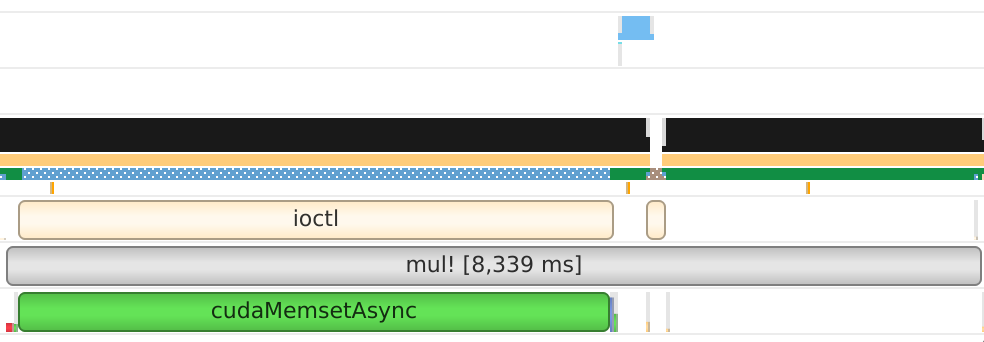

Note how our NVTX range nicely includes the time it took to queue the operation, as well as the execution on the GPU. This requires the NVTX range to include a synchronization!

The initial API call here is suspiciously slow though. This is a common occurence, and therefore it's recommended to profile any short-running application twice:

In [29]:
CUDA.@profile begin
    NVTX.@range "mul! 1" CUDA.@sync A * B
    NVTX.@range "mul! 2" CUDA.@sync A * B
end;


waiting for capture range to start the collection
command ignored
┌ Info: Profiling has finished, open the report listed above with `nsight-sys`
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:91


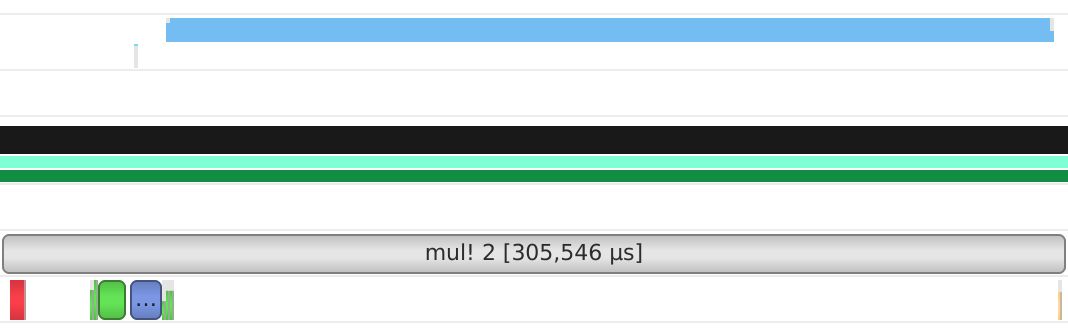

That's better, and much closer to our earlier benchmark results. Notice that it is still slightly slower, and some overhead is to be expected when running under the profiler.

NVTX can also be used to add markers to the source code:

In [30]:
CUDA.@profile begin
    NVTX.@range "mul! 1" CUDA.@sync A * B
    NVTX.@range "mul! 2" CUDA.@sync A * B
    NVTX.mark("done")
end;


waiting for capture range to start the collection
command ignored
┌ Info: Profiling has finished, open the report listed above with `nsight-sys`
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:91


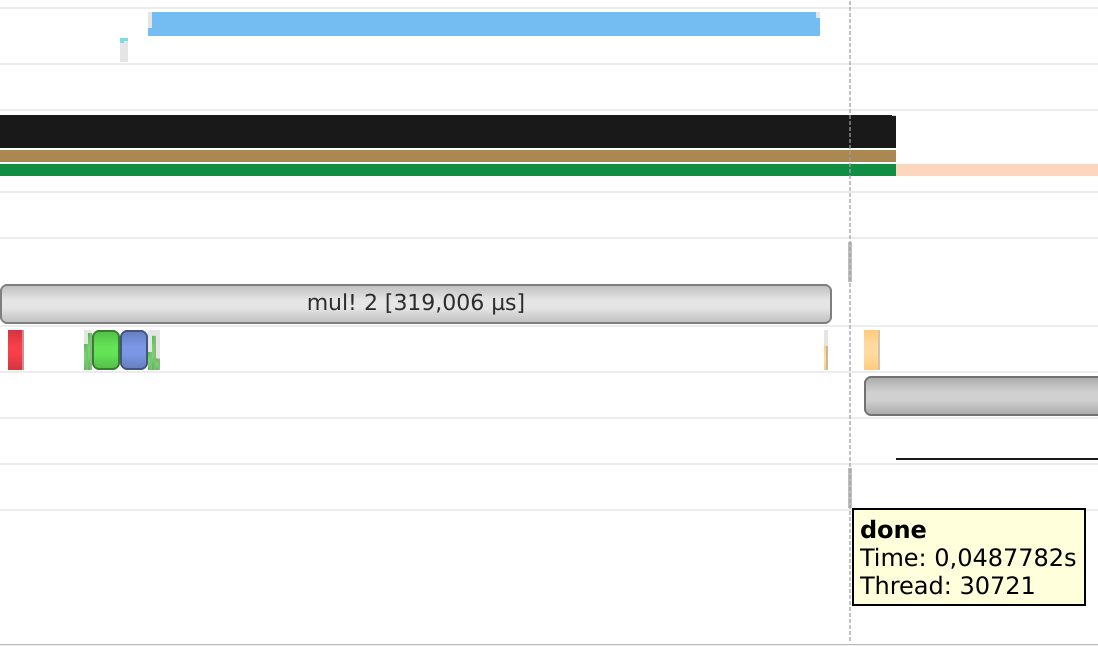

For details on the kernel's execution, expand the `GPU` part of the timeline and hover the kernel in question:

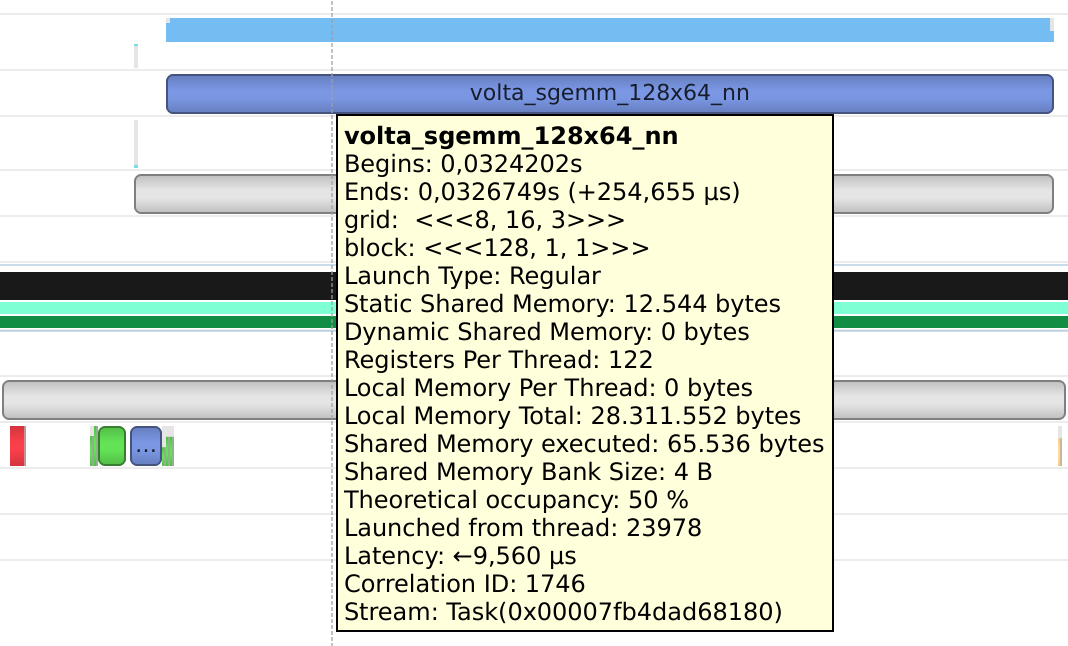

That gives some useful information on the kernel, but generally, there's more low-hanging fruit at the application level rather than at individual kernels.

## Case study: Batched RMSE

As a case study, let's look at a sequence of operations that computes the RMSE of a batch of matrices:

In [4]:
N = 16
A = CUDA.rand(1024, 1024, N)
B = CUDA.rand(1024, 1024, N)
CUDA.allowscalar(false)

In [31]:
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix)
    E = A - B
    SQE = E .^ 2
    MSE = sum(SQE) / length(SQE)
    return sqrt(MSE)
end

rmse (generic function with 1 method)

In [33]:
NVTX.@range function doit(f)
    rmses = Vector{Float64}(undef, N)
    for i in 1:N
        rmses[i] = f(A[:, :, i], B[:, :, i])
    end
    rmses
end

doit (generic function with 1 method)

In [34]:
@benchmark doit(rmse)

BenchmarkTools.Trial: 540 samples with 1 evaluation.
 Range (min … max):  2.755 ms … 294.130 ms  ┊ GC (min … max): 0.00% … 1.12%
 Time  (median):     3.349 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.261 ms ±  39.446 ms  ┊ GC (mean ± σ):  0.72% ± 0.16%

  █                                                            
  █▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▆ ▆
  2.76 ms      Histogram: log(frequency) by time       281 ms <

 Memory estimate: 114.97 KiB, allocs estimate: 2706.

<div class="alert alert-info">
Explicit synchronization is not required here, since we fetch the GPU memory by calling the `Array` function which requires the GPU to be idle.
</div>

To determine whether we're using the GPU efficiently, let's look at a timeline:

In [35]:
#CUDA.@profile (doit(rmse); doit(rmse))

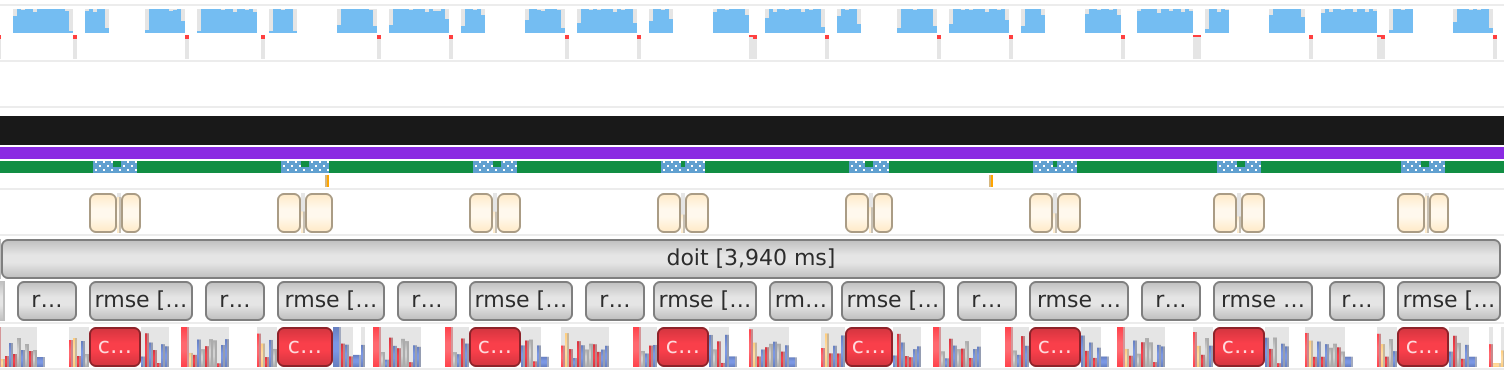

What we're generally looking for, is a continuous stream of kernels that keeps the GPU busy. That's not the case here, as there's lots of white space between blocks of kernels indicating the GPU is essentially idle at that time. This is generally caused by the CPU not being able to queue work quickly enough, so we need to avoid needless operations between launching subsequent kernels.

For example, there's some time being wasted before every invocation of the `rmse` function:

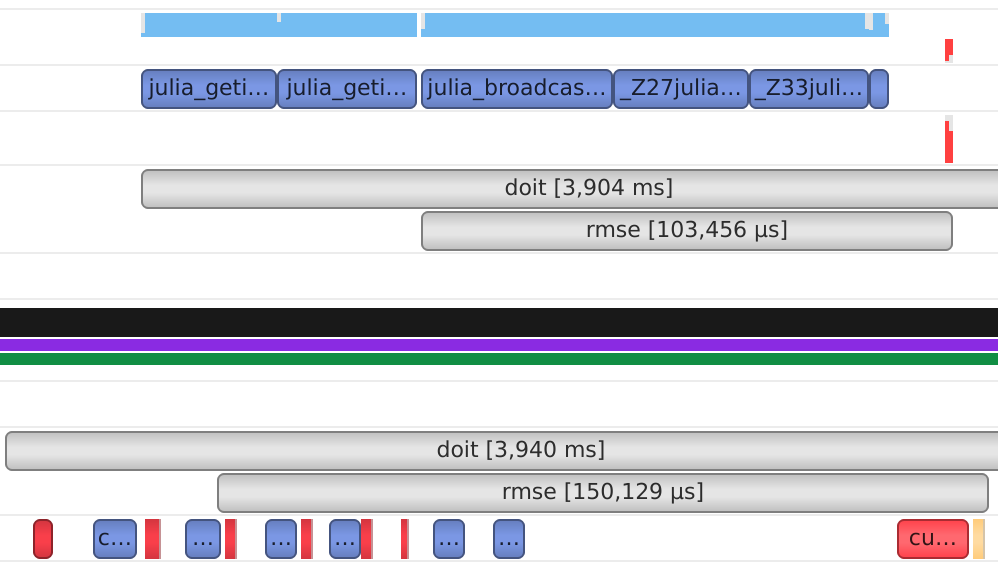

The cause for the overhead is the slicing of arrays, which copies data! Let's convert it into a view instead:

In [55]:
NVTX.@range function doit2(f)
    rmses = Vector{Float64}(undef, N)
    for i in 1:N
        rmses[i] = f(view(A, :, :, i), view(B, :, :, i))
    end
    rmses
end;

In [37]:
@benchmark doit2(rmse)

BenchmarkTools.Trial: 975 samples with 1 evaluation.
 Range (min … max):  1.958 ms … 283.754 ms  ┊ GC (min … max): 0.00% … 1.23%
 Time  (median):     2.104 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.211 ms ±  28.109 ms  ┊ GC (mean ± σ):  0.76% ± 0.14%

  █ ▁                                                          
  ███▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▇
  1.96 ms      Histogram: log(frequency) by time      57.2 ms <

 Memory estimate: 76.97 KiB, allocs estimate: 1522.

In [38]:
#CUDA.@profile (doit2(rmse); doit2(rmse))

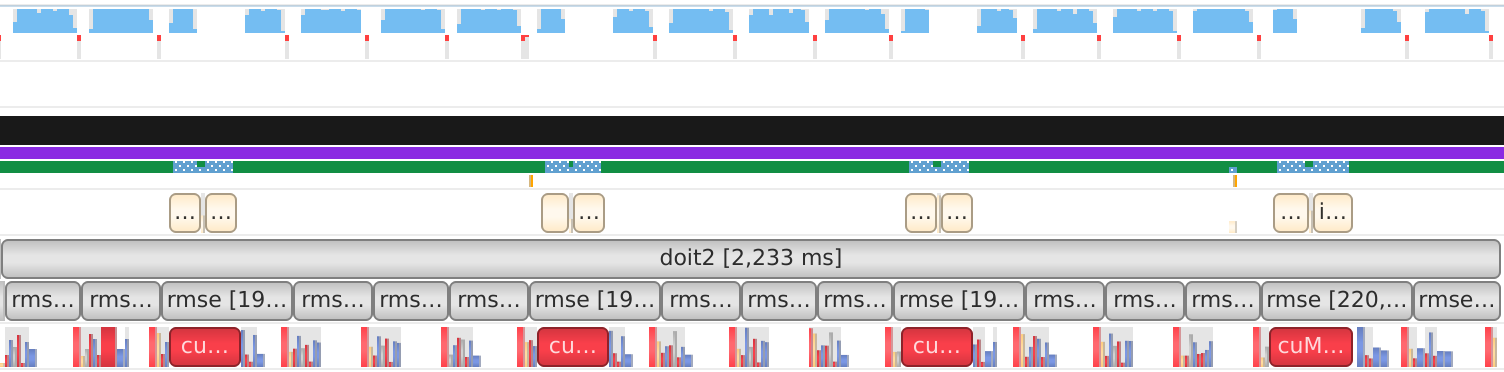

The invocations of the `rmse` function are now closely packed together, but the GPU trace itself is still very sparse: Lots of kernels are being launched, and there's lots of time where the GPU is essentially idle.

One typical approach to improving this is to fuse kernels:

In [56]:
NVTX.@range function rmse2(A::AbstractMatrix, B::AbstractMatrix)
    SQE = (A - B) .^ 2
    MSE = sum(SQE) / length(A)
    return sqrt(MSE)
end;

In [40]:
@benchmark doit2(rmse2)

BenchmarkTools.Trial: 975 samples with 1 evaluation.
 Range (min … max):  1.963 ms … 290.204 ms  ┊ GC (min … max): 0.00% … 1.49%
 Time  (median):     2.108 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.167 ms ±  28.155 ms  ┊ GC (mean ± σ):  0.80% ± 0.14%

  █▂                                                           
  ██▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▇
  1.96 ms      Histogram: log(frequency) by time        44 ms <

 Memory estimate: 76.97 KiB, allocs estimate: 1522.

In [41]:
#CUDA.@profile (doit2(rmse2); doit2(rmse2))

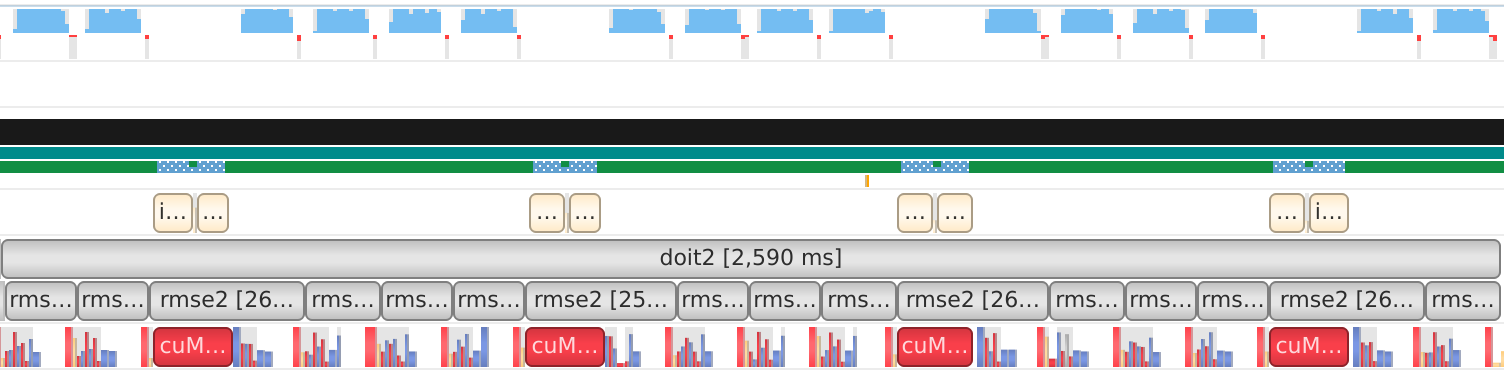

Not much of an improvement! That's because even though we saved quite some time on the GPU, the CPU was spending time doing some allocations and the GPU usage just became even more sparse. The good news is that by fusing even more, we also get rid of these temporaries, so it's a two-fold advantage:

In [57]:
NVTX.@range function rmse3(A::AbstractMatrix, B::AbstractMatrix)
    @assert size(A) == size(B)
    MSE = mapreduce((a,b)->(a - b) ^ 2, +, A, B) / length(A)
    return sqrt(MSE)
end;

In [43]:
@benchmark doit2(rmse3)

BenchmarkTools.Trial: 3994 samples with 1 evaluation.
 Range (min … max):  937.088 μs … 55.010 ms  ┊ GC (min … max): 0.00% … 26.64%
 Time  (median):       1.073 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.249 ms ±  1.865 ms  ┊ GC (mean ± σ):  1.40% ±  0.93%

  ▂▅▇██▇▇▆▅▃▂ ▁▁▁▂▁▁ ▁▁▂▃▃▃▃▃▃▂▁   ▁                           ▂
  ███████████████████████████████████▇█▇▇▆▅▇▁▄▅▆▅▄▄▄▄▄▄▄▄▄▁▄▄▇ █
  937 μs        Histogram: log(frequency) by time      2.45 ms <

 Memory estimate: 61.97 KiB, allocs estimate: 1218.

In [44]:
#CUDA.@profile (doit2(rmse3); doit2(rmse3))

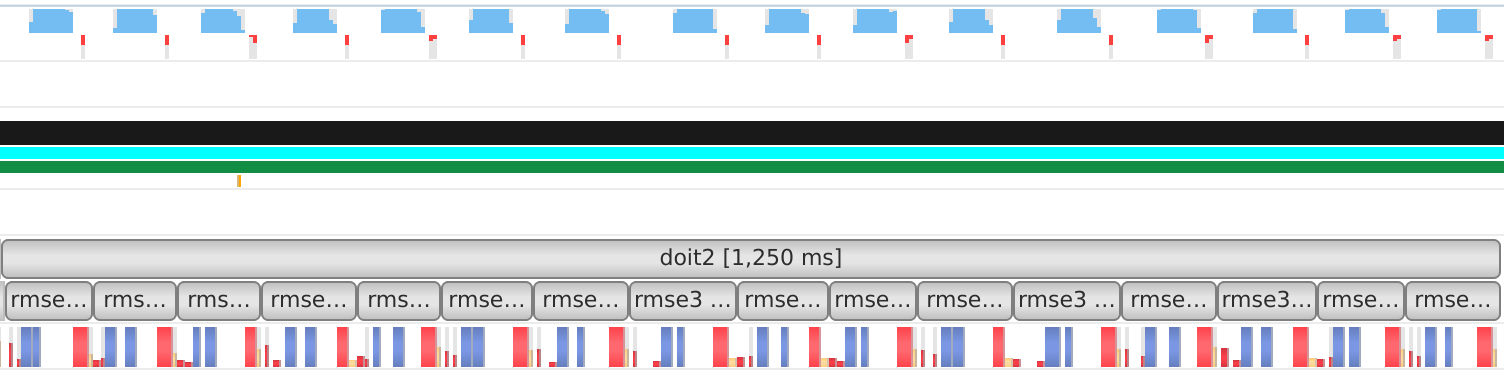

By fusing even more, we god rid of some costly temporaries. Yet the trace is still sparse. That's because `mapreduce` returns a scalar, so it needs to wait for the GPU to finish (i.e. it synchronizes execution). Let's reduce to a 1-element array instead, which we then fetch after having processed all batches:

In [58]:
NVTX.@range function rmse4(A::AbstractMatrix, B::AbstractMatrix)
    @assert size(A) == size(B)
    MSE = mapreduce((a,b)->(a - b) ^ 2, +, A, B; dims=(1,2)) ./ length(A)
    return sqrt.(MSE)
end

NVTX.@range function doit3(f)
    rmses = Vector(undef, N)
    for i in 1:N
        rmses[i] = f(view(A, :, :, i), view(B, :, :, i))
    end
    map(rmses) do rmse
        Array(rmse)[]
    end
end;

In [46]:
@benchmark doit3(rmse4)

BenchmarkTools.Trial: 4233 samples with 1 evaluation.
 Range (min … max):  714.351 μs … 74.900 ms  ┊ GC (min … max): 0.00% … 21.24%
 Time  (median):     996.827 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.178 ms ±  2.867 ms  ┊ GC (mean ± σ):  2.09% ±  0.85%

         ▃▆▇▇█▇▆▅▂▂                                             
  ▂▁▂▃▄▅▇███████████▇▆▅▄▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂ ▄
  714 μs          Histogram: frequency by time         1.98 ms <

 Memory estimate: 79.38 KiB, allocs estimate: 1686.

In [47]:
#CUDA.@profile (doit3(rmse4); doit3(rmse4))

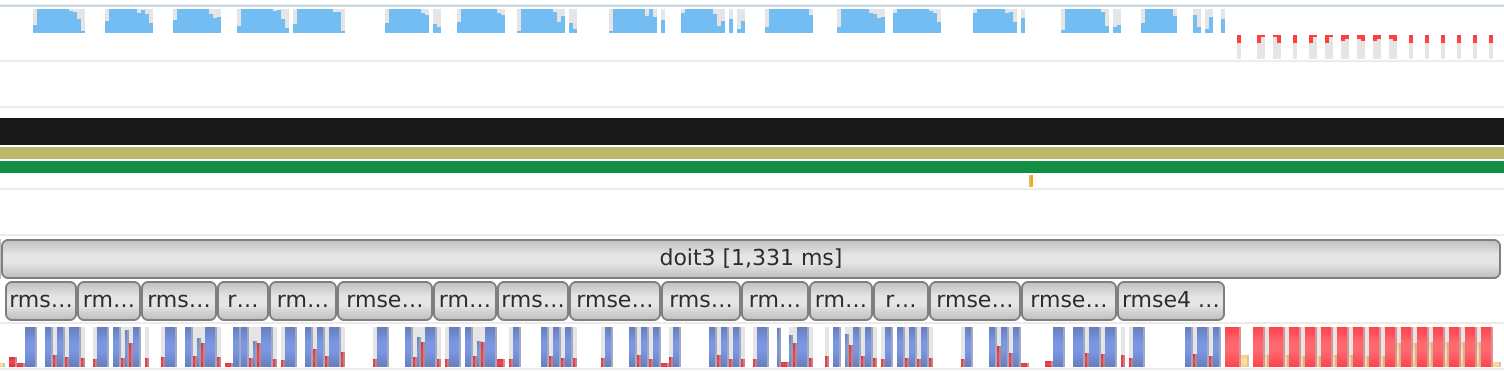

Quite an improvement! All synchronizing operations now happen at the end of the loop, so the GPU can keep on computing uninterruptedly. But at the end, we still require a bunch of memory operations; let's use a single buffer that we can fetch using a single memory copy. We can do so using `mapreducedim!`, a low-level abstraction that takes the destination array as an argument. The disadvantage of this API is that it only accepts a single input array, so we need to manually instantiate the broadcast (we could also do this using LazyArrays.jl):

In [59]:
NVTX.@range function rmse5(A::AbstractMatrix, B::AbstractMatrix, C::AbstractArray)
    SQE = Broadcast.broadcasted(A, B) do a,b
        (a - b) ^ 2
    end
    SQE = Broadcast.instantiate(SQE)
    Base.mapreducedim!(identity, +, C, SQE)
    C .= sqrt.(C ./ length(SQE))
    return
end

NVTX.@range function doit4(f)
    rmses = similar(A, 1, 1, N)
    fill!(rmses, zero(eltype(A)))
    
    for i in 1:N
        f(view(A, :, :, i), view(B, :, :, i), reshape(view(rmses, i), 1, 1))
    end
    Array(rmses)
end;

In [49]:
@benchmark doit4(rmse5)

BenchmarkTools.Trial: 5172 samples with 1 evaluation.
 Range (min … max):  604.962 μs … 52.860 ms  ┊ GC (min … max): 0.00% … 30.73%
 Time  (median):     863.859 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   963.744 μs ±  1.627 ms  ┊ GC (mean ± σ):  1.78% ±  1.04%

        ▂▃▄▅▇▆█▅▅▄▄▂▁▄▁                                         
  ▁▁▂▃▅▇███████████████▇█▆▅▅▅▄▄▃▃▃▂▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  605 μs          Histogram: frequency by time         1.63 ms <

 Memory estimate: 64.09 KiB, allocs estimate: 1192.

In [50]:
#CUDA.@profile (doit4(rmse5); doit4(rmse5))

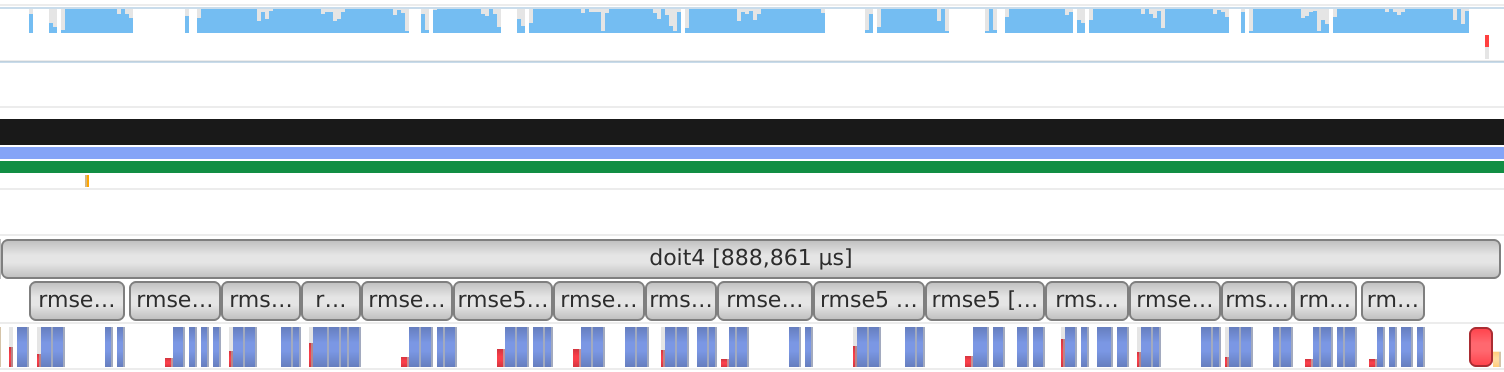

Now the GPU trace is starting to look nicely packed.

Of course, this entire exercise is slightly contrived, and we could have started out by getting rid of the `for` loop and using array operations across the batch dimension:

In [5]:
NVTX.@range function rmse6(A::AbstractArray, B::AbstractArray, C::AbstractArray)
    SQE = Broadcast.broadcasted(A, B) do a,b
        (a - b) ^ 2
    end
    SQE = Broadcast.instantiate(SQE)
    Base.mapreducedim!(identity, +, C, SQE)
    C .= sqrt.(C ./ prod(size(A)[1:2]))
    return
end

NVTX.@range function doit5(f)
    rmses = similar(A, 1, 1, N)
    fill!(rmses, zero(eltype(A)))
    f(A, B, rmses)
    Array(rmses)
end;

In [ ]:
@benchmark doit5(rmse6)

In [53]:
#CUDA.@profile (doit5(rmse6); doit5(rmse6))

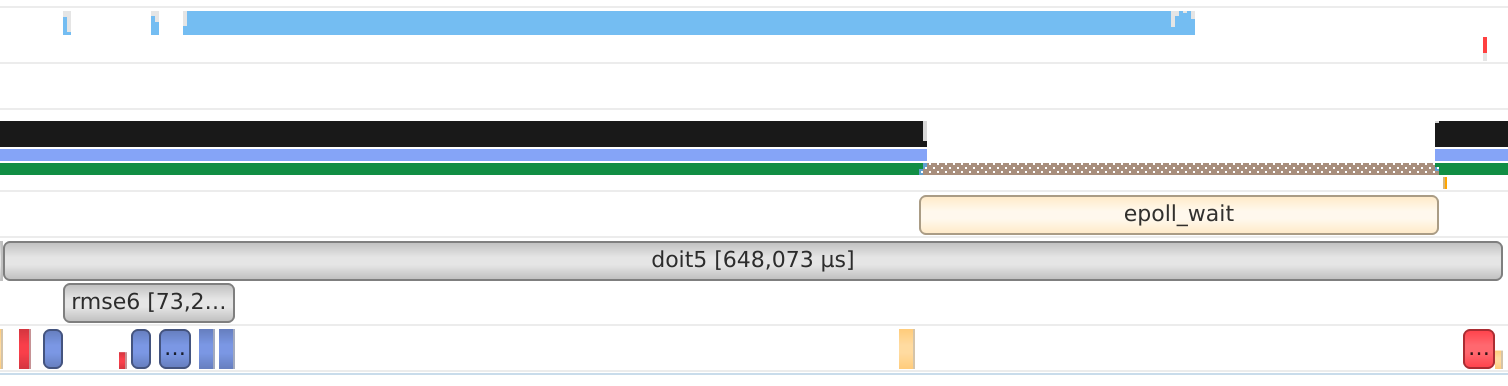

By getting rid of the loop, we only need to launch a single series of kernels, so the effects of using unfused kernels would have been less pronounced. Still, the individual optimizations were worth it, even when processing all batches at once.

In [6]:
doit5(rmse6)

1×1×16 Array{Float32, 3}:
[:, :, 1] =
 0.40808734

[:, :, 2] =
 0.40841258

[:, :, 3] =
 0.40840292

...

[:, :, 14] =
 0.40811127

[:, :, 15] =
 0.4081969

[:, :, 16] =
 0.40829718

In [10]:
using Tullio, KernelAbstractions, CUDAKernels

Summarized, when optimizing a GPU application it's good to:

- fuse operations: avoids temporaries, reduces launch overhead, and enables global optimization
- avoid synchronization: either explicit, or implicit (e.g. using pinned memory)
- bundle memory operations: pre-allocation, fetch results at the end

Many of these optimization can be implemented generically, i.e., without introducing GPU-specific operations (e.g. avoiding calls to constructors but use `similar`, ...). As a result, it's still possible to use the above functions with CPU arrays, even with the NVTX annotations still attached to them:

In [ ]:
A = rand(Float32, 1024, 1024, N)
B = rand(Float32, 1024, 1024, N)
@benchmark doit3(rmse4)

### Bonus exercise: Batched matrix RMSE with index notation

Although the above exercise served great for demonstrating common optimization patterns, the operation in question can be easily expressed using index notation.

In [14]:
@tullio C[k] := (A[i,j,k] - B[i,j,k])^2 |> sqrt(_ / (size(A,1)*size(A,2)))

16-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.40797395
 0.40829885
 0.40828407
 0.40840244
 0.40819484
 0.40798712
 0.4082529
 0.40822423
 0.4080547
 0.40826848
 0.40865508
 0.40774432
 0.40778053
 0.4080058
 0.40808594
 0.40818048